# Data Source: GeoDist: The CEPII's distances and geographical database
Bilateral distances between the largest cities of those two countries (in terms
of population)

In [1]:
import pandas as pd
import pickle
import numpy as np
import sklearn

In [2]:
dis_df = pd.read_stata('dist_cepii.dta')

In [3]:
dis_df

,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,distw,distwces
0,ABW,ABW,0,0,0,0,0,0,0,0,5.225315,5.225315,25.093539,23.047228
1,ABW,AFG,0,0,0,0,0,0,0,0,13257.814453,13257.814453,13168.223762,13166.366934
2,ABW,AGO,0,0,0,0,0,0,0,0,9516.913086,9516.913086,9587.315563,9584.193415
3,ABW,AIA,0,0,1,0,0,0,0,0,983.268250,983.268250,976.897355,976.891580
4,ABW,ALB,0,0,0,0,0,0,0,0,9091.742188,9091.742188,9091.575727,9091.465815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50171,ZWE,YUG,0,0,0,0,0,0,0,0,7056.401855,7056.401855,7046.432349,7042.830362
50172,ZWE,ZAF,1,1,1,0,0,0,0,0,2186.205811,926.174255,1258.552190,1101.437596
50173,ZWE,ZAR,0,0,0,0,0,0,0,0,2283.061035,2283.061035,1930.976364,1719.146688
50174,ZWE,ZMB,1,1,1,0,1,0,0,0,396.804077,396.804077,583.795373,525.073446


In [4]:
with open('../pkl/global_weekly_sorted_tensor2.pkl', 'rb') as f:
    travel_tensor_raw = pickle.load(f) 
    
with open('../pkl/new_country_order.pkl', 'rb') as f:
    new_order = pickle.load(f) 

In [5]:
country_cutline = 30 # 69, 70 give None homogeneity
travel_tensors = travel_tensor_raw[:,0:country_cutline,0:country_cutline]

travel_df = pd.read_csv('../csv/global_travel_df.csv')
countries = travel_df['node'].unique().T

label_dict = dict(zip(np.char.mod('%d', range(226)), countries[new_order]))
label_dict = dict(zip(range(country_cutline), countries[new_order]))

adj_list = []
interval = 50 # 26 * 4 weeks = 2 year,
for i in range(interval):
    ajm = np.sum(travel_tensors[4*i:4 + 4*i][:,0:country_cutline,0:country_cutline], axis=0)
    adj_list.append(ajm)
travel_tensors = np.array(adj_list)

In [6]:
travel_tensors.shape

(50, 30, 30)

In [7]:
label_dict

{0: 'US',
 1: 'GB',
 2: 'FR',
 3: 'ES',
 4: 'IT',
 5: 'DE',
 6: 'MX',
 7: 'CA',
 8: 'JP',
 9: 'NL',
 10: 'BR',
 11: 'TH',
 12: 'ID',
 13: 'MY',
 14: 'SG',
 15: 'BE',
 16: 'AE',
 17: 'AU',
 18: 'CH',
 19: 'PH',
 20: 'IE',
 21: 'PT',
 22: 'AR',
 23: 'TR',
 24: 'RU',
 25: 'KW',
 26: 'CN',
 27: 'IN',
 28: 'HK',
 29: 'AT'}

In [8]:
attract = np.sum(travel_tensors, 1) # attractiveness
emit = np.sum(travel_tensors, 2) # emmisiveness
mean_adj = np.mean(travel_tensors,0)

In [9]:
avg_attract = np.mean(attract, 0)
avg_emit = np.mean(emit, 0)

In [10]:
ccode = pd.read_csv('countries_codes_and_coordinates.csv').replace('"','', regex=True).replace(' ','', regex=True)

In [11]:
label2 = list(label_dict.values())

In [12]:
label3 = []
for i in range(len(label2)):
    for j in range(len(ccode)):
        if(label2[i]==ccode.iloc[j,1]):
            if(ccode.iloc[j,2] == ccode.iloc[j-1,2]):
                continue
            label3.append(ccode.iloc[j,2])

In [13]:
gravity_df = np.zeros([country_cutline*country_cutline,4])
line = 0
for i in range(country_cutline):
    for j in range(country_cutline):
        e = avg_emit[i]
        a = avg_attract[j]
        source = label3[i]
        target = label3[j]
        y = mean_adj[i,j]
        d = dis_df[(dis_df['iso_o']==source) & (dis_df['iso_d']==target)]['dist']
        if((source==target)
           |(len(d)==0)
           |(y<1)
          ):
            e,a,d,y = -1,-1,-1,0
        gravity_df[line,0] = e
        gravity_df[line,1] = a
#         print(i,j,d)
        gravity_df[line,2] = d
        gravity_df[line,3] = y
        line += 1

In [14]:
gravity_df = pd.DataFrame(gravity_df)
gravity_df.columns = ['emit','attract','distance','T']
gravity_df = gravity_df[gravity_df['T']!=0]

In [15]:
import copy
gravity_df_bak = copy.deepcopy(gravity_df)

In [16]:
# gravity_df = gravity_df_bak

In [17]:
def scale(em):
    return em+np.exp(1)
#     return 10+90*(em-np.min(em))/(np.max(em)-np.min(em))

In [18]:
gravity_df['emit'] = scale(gravity_df['emit'])
gravity_df['attract'] = scale(gravity_df['attract'])
gravity_df['distance'] = scale(gravity_df['distance'])
gravity_df['T'] = scale(gravity_df['T'])

In [19]:
log_grav_df = np.log(gravity_df)

In [20]:
log_grav_df['T']

1      3.446116
2      2.896921
3      2.370083
4      2.527190
5      2.483095
         ...   
859    1.516946
866    1.390854
871    1.380850
874    1.444158
875    1.901851
Name: T, Length: 223, dtype: float64

In [21]:
log_grav_df#.to_csv('log_grav_df.csv')
np.min(log_grav_df['T'])

1.3132616875182228

# Right skewed log(T)

Text(0.5, 1.0, 'Histogram of y = log(T) ')

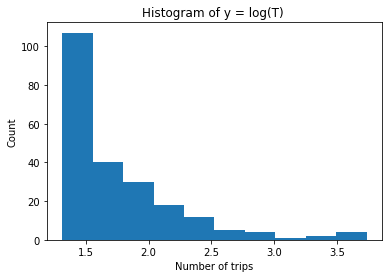

In [22]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(12,12))
# plt.scatter(log_grav_df['attract'], log_grav_df['y'])
plt.hist(log_grav_df['T'])
plt.ylabel('Count')
plt.xlabel('Number of trips')
plt.title('Histogram of y = log(T) ')

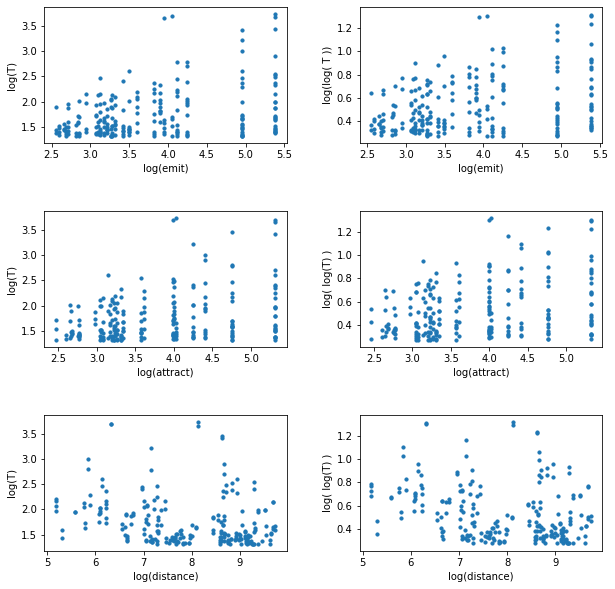

In [23]:
fig = plt.figure(figsize=[10,10])
plt.subplot(3, 2, 1)
plt.scatter(log_grav_df['emit'],(log_grav_df['T']), s=10)
# plt.hlines(0,2,5.5, color='red')
plt.xlabel('log(emit)'); plt.ylabel('log(T)')
plt.subplot(3, 2, 2)
plt.scatter(log_grav_df['emit'],np.log(log_grav_df['T']), s=10)
plt.xlabel('log(emit)'); plt.ylabel('log(log( T ))')

plt.subplot(3, 2, 3)
plt.scatter(log_grav_df['attract'],(log_grav_df['T']), s=10)
plt.xlabel('log(attract)'); plt.ylabel('log(T)')
# plt.hlines(0,2,5.5, color='red')
plt.subplot(3, 2, 4)
plt.scatter(log_grav_df['attract'],np.log(log_grav_df['T']), s=10)
plt.xlabel('log(attract)'); plt.ylabel('log( log(T) )')

plt.subplot(3, 2, 5)
plt.scatter(log_grav_df['distance'],(log_grav_df['T']), s=10)
plt.xlabel('log(distance)'); plt.ylabel('log(T)')
# plt.hlines(0,5,9.9, color='red')
plt.subplot(3, 2, 6)
plt.scatter(log_grav_df['distance'],np.log(log_grav_df['T']), s=10)
plt.xlabel('log(distance)'); plt.ylabel('log( log(T) )')

fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [24]:
# plt.hist(np.log(log_grav_df_processed['T']), bins =30)

In [25]:
import statsmodels.api as sm
log_grav_df_processed = log_grav_df[log_grav_df['T']>0]
X = (log_grav_df_processed[['emit','attract','distance']])
y = (log_grav_df_processed['T'])

glm = sm.GLM(y, sm.add_constant(X), family=sm.families.InverseGaussian(link=sm.families.links.inverse_power))
# glm = sm.OLS(y, X)
# glm = sm.GLM(y, X, family=sm.families.Tweedie(link=sm.families.links.identity, var_power=0.1))
result = glm.fit()
result.summary()
# gamma_model = smf.glm(formula='y ~ emit + attract + distance', data=log_grav_df, family=sm.families.Gaussian(sm.families.links.identity))
# gamma_results = gamma_model.fit()
# print(gamma_results.summary())

/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  
/Users/gimpuleumoe/opt/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The inverse_power link function does not respect the domain of the InverseGaussian family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      T   No. Observations:                  223
Model:                            GLM   Df Residuals:                      219
Model Family:         InverseGaussian   Df Model:                            3
Link Function:          inverse_power   Scale:                        0.016558
Method:                          IRLS   Log-Likelihood:                -28.777
Date:                Mon, 05 Oct 2020   Deviance:                       3.4001
Time:                        16:20:59   Pearson chi2:                     3.63
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8628      0.059     14.689      0.000       0.748       0.978
emit          -0.0897      0.008    -11.373      0.000      -0.105      -0.074
attract       -0.0876      0.008    -10.488      0.000      -0.104      -0.071
distance       0.0506      0.005      9.441      0.000       0.040       0.061
==============================================================================
"""

In [26]:
result.pvalues

const       7.555368e-49
emit        5.673208e-30
attract     9.809643e-26
distance    3.709638e-21
dtype: float64

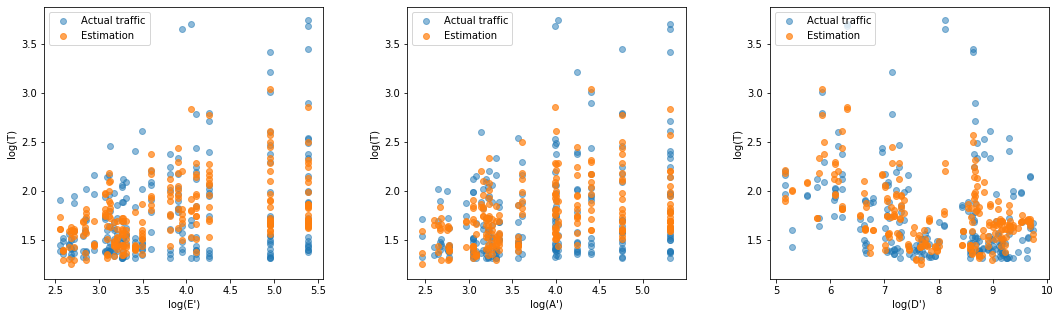

In [27]:
pred = result.predict(sm.add_constant(log_grav_df_processed[['emit','attract','distance']]))

fig = plt.figure(figsize=[18,5])
plt.subplot(1, 3, 1)
X= log_grav_df_processed['emit']
plt.scatter(X,y, alpha=0.5, label = 'Actual traffic')
plt.scatter(X,pred, alpha=0.7, label = 'Estimation')
plt.xlabel("log(E')")
plt.ylabel("log(T)")
plt.legend()

plt.subplot(1, 3, 2)
X= log_grav_df_processed['attract']
plt.scatter(X,y, alpha=0.5, label = 'Actual traffic')
plt.scatter(X,pred, alpha=0.7, label = 'Estimation')
plt.xlabel("log(A')")
plt.ylabel("log(T)")
plt.legend()

plt.subplot(1, 3, 3)
X= log_grav_df_processed['distance']
plt.scatter(X,y, alpha=0.5, label = 'Actual traffic')
plt.scatter(X,pred, alpha=0.7, label = 'Estimation')
plt.xlabel("log(D')")
plt.ylabel("log(T)")
plt.legend(loc='upper left')

fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [28]:
# import statsmodels.api as sm

# X = (log_grav_df_processed[['emit','attract','distance']])
# y = (log_grav_df_processed['T'])

# # Note the difference in argument order
# model = sm.OLS((y), X).fit()
# predictions = model.predict(X) # make the predictions by the model

# # Print out the statistics
# model.summary()

In [29]:
week_slices = pd.date_range('2016-01-04', periods=200+1, freq='W')
xaxis = week_slices[0::4]

In [30]:
cnt1=24
cnt2=0
time = -18
RU_emit = scale(np.sum(travel_tensors[time,:], 1))[cnt1]
US_emit = scale(np.sum(travel_tensors[time,:], 1))[cnt2]
RU_attract = scale(np.sum(travel_tensors[time,:], 0))[cnt1]
US_attract = scale(np.sum(travel_tensors[time,:], 0))[cnt2]
d = dis_df[(dis_df['iso_o']==label3[cnt2])&(dis_df['iso_d']==label3[cnt1])]['dist']
d = np.float(d)
d = scale(d)

In [31]:
# pred_RU_to_US = result.predict(np.log([RU_emit, US_attract, d]))
# pred_US_to_RU = result.predict(np.log([US_emit, RU_attract, d]))
pred_US_to_RU_list = []
pred_RU_to_US_list = []
for time in range(24):
    RU_emit = np.sum(travel_tensors[-24+time,:], 1)[cnt1]
    US_emit = np.sum(travel_tensors[-24+time,:], 1)[cnt2]
    RU_attract = np.sum(travel_tensors[-24+time,:], 0)[cnt1]
    US_attract = np.sum(travel_tensors[-24+time,:], 0)[cnt2]
    d = dis_df[(dis_df['iso_o']==label3[cnt2])&(dis_df['iso_d']==label3[cnt1])]['dist']
    d = np.float(d)
    #
    RU_emit = scale(RU_emit)
    US_emit = scale(US_emit)
    RU_attract = scale(RU_attract)
    US_attract = scale(US_attract)
    d = scale(d)
    #
    input1= np.log(np.array([US_emit, RU_attract, d]))
    pred_US_to_RU = result.predict(np.append(1,input1))
    pred_US_to_RU = ((np.exp(pred_US_to_RU)))-np.exp(1)
    pred_US_to_RU_list.append(pred_US_to_RU)
    #
    input2 = np.log(np.array([RU_emit, US_attract, d]))
    pred_RU_to_US = result.predict(np.append(1,input2))
    pred_RU_to_US = ((np.exp(pred_RU_to_US))) - np.exp(1)
    pred_RU_to_US_list.append(pred_RU_to_US)

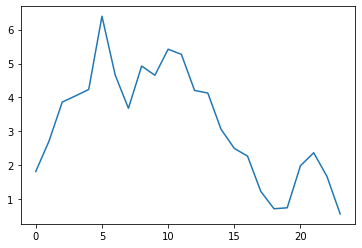

In [32]:
plt.plot(pred_US_to_RU_list)

In [33]:
# # pred_RU_to_US = result.predict(np.log([RU_emit, US_attract, d]))
# # pred_US_to_RU = result.predict(np.log(np.array([US_emit, RU_attract, d])+1e-30))
# pred_US_to_RU_list = []
# pred_RU_to_US_list = []
# for time in range(24):
#     RU_emit = np.sum(travel_tensors[time,:], 1)[cnt1]
#     US_emit = np.sum(travel_tensors[time,:], 1)[cnt2]
#     RU_attract = np.sum(travel_tensors[time,:], 0)[cnt1]
#     US_attract = np.sum(travel_tensors[time,:], 0)[cnt2]
#     #
#     RU_emit = scale(RU_emit)
#     US_emit = scale(US_emit)
#     RU_attract = scale(RU_attract)
#     US_attract = scale(US_attract)
#     #
#     d = dis_df[(dis_df['iso_o']==label3[cnt2])&(dis_df['iso_d']==label3[cnt1])]['dist']
#     d = np.float(d)
#     d = scale(d)
#     pred_US_to_RU = result.predict(np.log(np.array([US_emit, RU_attract, d])))
#     pred_US_to_RU = np.exp(np.exp(pred_US_to_RU))-np.exp(1)
#     pred_US_to_RU_list.append(pred_US_to_RU)
#     pred_RU_to_US = result.predict(np.log(np.array([RU_emit, US_attract, d])))
#     pred_RU_to_US = np.exp(np.exp(pred_RU_to_US))-np.exp(1)
#     pred_RU_to_US_list.append(pred_RU_to_US)

In [34]:
xaxis[-20]

Timestamp('2018-05-27 00:00:00', freq='4W-SUN')

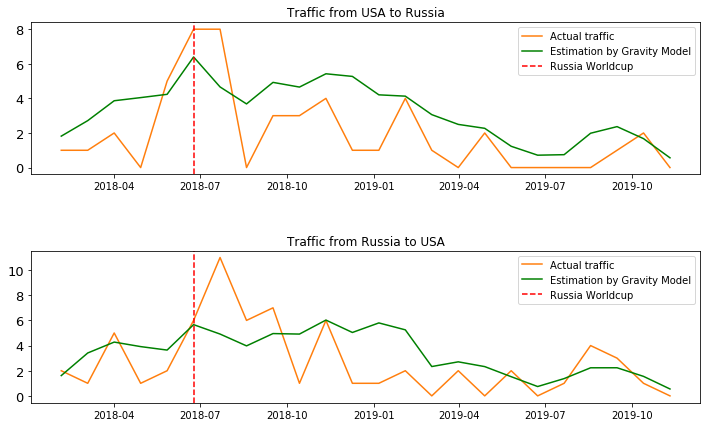

In [49]:
time = -19

fig = plt.figure(figsize=[12,7])
plt.subplot(2, 1, 1)
plt.plot(xaxis[-24:],travel_tensors[-24:,cnt2,cnt1], color='C1', label='Actual traffic')
plt.plot(xaxis[-24:],(pred_US_to_RU_list), color='green', label='Estimation by Gravity Model')
plt.axvline(xaxis[time], linestyle='--', label='Russia Worldcup', color='red')
plt.title('Traffic from USA to Russia')
plt.yticks(fontsize=13)
plt.legend()

plt.subplot(2, 1, 2)
plt.yticks(fontsize=13)
plt.plot(xaxis[-24:],travel_tensors[-24:,cnt1,cnt2], color='C1', label='Actual traffic')
plt.plot(xaxis[-24:],(pred_RU_to_US_list), color='green', label='Estimation by Gravity Model')
plt.axvline(xaxis[time], linestyle='--', label='Russia Worldcup', color='red')
plt.title('Traffic from Russia to USA')
plt.legend()

fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [36]:
# cnt1=24
# cnt2=0
# time = -18
RU_emit = np.sum(travel_tensors[time,:], 1)[cnt1]
US_emit = np.sum(travel_tensors[time,:], 1)[cnt2]
RU_attract = np.sum(travel_tensors[time,:], 0)[cnt1]
US_attract = np.sum(travel_tensors[time,:], 0)[cnt2]
d = dis_df[(dis_df['iso_o']==label3[cnt2])&(dis_df['iso_d']==label3[cnt1])]['dist']
d = np.float(d)

In [37]:
logT_RUtoUS = np.log(travel_tensors[time,cnt1,cnt2])
logT_UStoRU = np.log(travel_tensors[time,cnt2,cnt1])

In [38]:
pred = result.predict(log_grav_df_processed[['emit','attract','distance']])
pred_RU_to_US = result.predict(np.log([RU_emit, US_attract, d]))
pred_US_to_RU = result.predict(np.log([US_emit, RU_attract, d]))

fig = plt.figure(figsize=[18,5])
plt.subplot(1, 3, 1)
X= log_grav_df_processed['emit']
plt.scatter(X,log_grav_df_processed['T'], alpha=0.1)
plt.scatter(X,pred, alpha=0.1)
plt.scatter(np.log(US_emit), logT_UStoRU, color='red', label = 'History')
plt.scatter(np.log(US_emit), pred_US_to_RU, label = 'Estimation')
plt.xlabel("log(E)")
plt.ylabel("log(T)")
plt.legend()

plt.subplot(1, 3, 2)
X= log_grav_df_processed['attract']
plt.scatter(X,log_grav_df_processed['T'], alpha=0.1)
plt.scatter(X,pred, alpha=0.1)
plt.scatter(np.log(RU_attract), logT_UStoRU, color='red', label = 'History')
plt.scatter(np.log(RU_attract), pred_US_to_RU, label = 'Estimation')
plt.xlabel("log(A)")
plt.ylabel("log(T)")
plt.legend()

plt.subplot(1, 3, 3)
X= log_grav_df_processed['distance']
plt.scatter(X,log_grav_df_processed['T'], alpha=0.1)
plt.scatter(X,pred, alpha=0.1)
plt.scatter(np.log(d), logT_UStoRU, color='red', label = 'History')
plt.scatter(np.log(d), pred_US_to_RU, label = 'Estimation')

plt.xlabel("log(D)")
plt.ylabel("log(T)")
plt.legend()

fig.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ValueError: shapes (223,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

In [ ]:
plt.hist(log_grav_df_processed['T'], bins=30)

In [ ]:
# 100 0.770
# 80, 0.738
# 70, 0.727
# cutline = 60, R2 = 0.701
# cutline = 50, R2 = 0.66
# cutline = 40, R2 = 0.62


In [ ]:
# Mean >= 1 filter
# 100, 0.656
# 70, 0.660